# TITULO FODA

titulo foda do trabalho, ilum escola de ciencias, nossos nomes (te amo)

# Introdução

Algo teórico sobre colisões e pq é legal de prever os jets etc

explicar o objetivo do trabalho e o dataset.

## Importações

Vamos começar importando as bibliotecas necessárias para os códigos do projeto. Utilizamos as bibliotecas `pandas` e `numpy` para a manipulação e análise do dataset, `matplotlib` para visualização de gráficos, e `optuna` para otimização de hiperparâmetros.

Do scikit-learn, usamos módulos para divisão dos dados, normalização, criação de pipelines, treinamento de modelos de classificação e avaliação de desempenho.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from sklearn.linear_model import LogisticRegression


## Tratamento de dados

Como visto na introdução, o dataset `MultiJetRun2010B`oriundo da CMS/CERN será utilizado. Contido nele há eventos de colisões de prótons com várias medições físicas detectadas, como:

`MR`: Escala de massa do evento

`Rsq`: Variável relacionada à energia e momento do evento

`E1`, `E2`: Energias dos dois jatos principais

`Px1`, `Py1`, `Pz1`, `Px2`, `Py2`, `Pz2`: Componentes do momento linear em cada direção espacial dos dois jatos

`HT`: Soma escalar dos momentos transversos de todos os jatos

`MET`: Energia transversal ausente – Missing Transverse Energy

A coluna `nJets` representa o número de jatos de hádrons detectados em cada colisão e será utilizado como target no processo de classificação.


In [2]:
pd.set_option("display.max_rows", 6)

df = pd.read_csv(r"Dataset\MultiJetRun2010B.csv")
df

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,148029,388,302318745,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2,0
1,148029,388,302323641,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2,0
2,148029,388,302336217,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,149181,1804,1703621104,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4,0
21724,149181,1804,1703642752,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2,0
21725,149181,1804,1703634776,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4,0


As colunas `Run`, `Lumi` e `Event` são apenas para identificação de eventos, então podemos retirá-las. O mesmo vale para a `nBJets` pois o mesmo não é relevante para o nosso trabalho.

Dessa forma, iremos definir apenas os dados que nos interessa como atributos, além de definir a `nJets` como target.

In [3]:
atributos = ["MR", "Rsq", "E1", "Px1", "Py1", "Pz1", "E2", "Px2", "Py2", "Pz2", "HT", "MET"]
target = ["nJets"]

df = df.reindex(atributos + target, axis=1)
df = df.dropna()
df

,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets
0,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2
1,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2
2,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4
21724,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2
21725,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4


Antes de continuarmos, é necessário observar algo sobre o target.

In [4]:
contagem = df["nJets"].value_counts()
print(contagem)

porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1325
5      169
6       23
7        3
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.098684
5     0.777870
6     0.105864
7     0.013808
Name: proportion, dtype: float64


Note que as classes de contagem de jets "4" pra cima possuem uma frequência muito baixa, sendo praticamente irrelevantes para o treinamento futuro. Portanto, podemos agrupá-lás para amenizar isso.

In [5]:
df["nJets"] = df["nJets"].apply(lambda x: x if x <= 3 else 4)

contagem = df["nJets"].value_counts()
print(contagem)
porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1520
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.996226
Name: proportion, dtype: float64


Dessa forma, a classe "4" para os `nJets` passa a indicar "4 ou mais" jets detectados.

Perceba que ainda há um desbalanceamento na frequência das classes. Isso pode afetar de maneira negativa os modelos, pois ele tende a aprender mais sobre a classe majoritária e ignorar as minoritárias. 

Para corrigir isso, utilizaremos de técnicas de `atribuição de pesos de classe`, dando mais importância às classes minoritárias durante o treinamento. Esse conceito será melhor explicado mais à frente do trabalho.

### Split dos dados

A forma como dividimos os dados entre treino e teste também deve ser cuidadosamente definida, garantindo que todos os modelos sejam avaliados de maneira justa. A semente aleatória atua como um hiperparâmetro que deve ser fixado antes do treinamento, assegurando que a divisão dos dados e quaisquer processos aleatórios sejam consistentes entre diferentes execuções. Embora não influencie diretamente a acurácia do modelo, ela é fundamental para reprodutibilidade dos resultados. 

Para este estudo, iremos reservar 20% dos dados para teste, enquanto o restante será alocado para treino. Além disso, manteremos a proporção das classes de `nJets` equilibrada entre os conjuntos de treino e teste utilizando o argumento `stratify`.

In [6]:
semente_aleatoria = 2307 #amo esse numero totalmente aleatorio
tamanho_teste = 0.2

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state=semente_aleatoria, stratify=df["nJets"]
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino[atributos].values
y_treino = df_treino[target].values.ravel()

X_teste = df_teste[atributos].values
y_teste = df_teste[target].values.ravel()


Usaremos o `StandardScaler` para normalizar os atributos, transformando-os para que tenham média zero e desvio padrão 1. Isso evita que variáveis com escalas maiores dominem o modelo e garante que algoritmos sensíveis à magnitude dos dados funcionem de maneira eficiente.

In [7]:
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

# Treinamento dos modelos

## Métrica de desempenho

A métrica escolhida para avaliar o desempenho dos modelos foi o `F1-score weighted`. Primeiramente, o `F1-score` é uma métrica que combina precisão (precision) e revocação (recall).

**Precisão** refere-se à fração de valores que foram corretamente identificados com um determinado rótulo em relação a todos os valores que foram corretamente identificados.

Já **revocação** refere-se a quantos valores com determinado rótulo foram corretamento identificados considerando todos que possuem esse rótulo.

Através da média harmônica entre precision e recall, encontra-se o `F1-score`:

$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

A sua versão ponderada (`F1-score weighted`) tem como diferencial o fato de que ela leva em conta a frequência de cada classe no conjunto de dados ao calcular o valor final. Dessa forma, o impacto das classes com mais exemplos é proporcionalmente maior, o que torna a métrica mais representativa em problemas com classes desbalanceadas. Essa variação é dada por:

$$
F1_{weighted} = \sum_{i=1}^{n} w_i \times F1_i
$$

Onde,

$$
w_i = \frac{\text{Número de amostras na classe } i}{\text{Número total de amostras}}
$$

## Árvore de Decisão

A árvore de decisão é um algoritmo de classificação  que organiza os dados em uma estrutura hierárquica de divisões, onde cada nó separa os exemplos em subconjuntos menores com base nos atributos disponíveis. Esse processo continua até atingir as folhas, que representam a classe final prevista para cada exemplo [Figura 1].

O funcionamento da árvore consiste em analisar todos os dados disponíveis e, em cada nó, realizar a divisão que melhor separa as classes de acordo com um critério de impureza. Cada divisão cria novos nós, e o processo se repete até que não haja mais subdivisões necessárias, determinando a classe predita em cada folha.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/decision-tree.png" alt="Estrutura comum da decision tree" width="600">
  <figcaption><b>Figura 1.</b> Estrutura comum de uma árvore de decisão.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Christonasis Antonios Marios - traintestsplit.com</figcaption>
</figure>
<br>

Em nosso trabalho, iremos treinar um modelo de Árvore de Decisão para prever `nJets` a partir de atributos físicos das colisões de prótons. Para isso, utilizaremos um `pipeline` que inclui padronização dos dados, e faremos otimização de hiperparâmetros com o Optuna para obter o melhor desempenho do modelo, levando em consideração também o desbalanceamento das classes por meio de pesos.

------------------------------------------------------------------------------------------------------------------

Quando trabalhamos com classes desbalanceadas, o modelo pode ficar tendencioso para a classe majoritária. Isso acontece porque, sem ajustes, o algoritmo não penaliza suficientemente os erros das classes minoritárias, que são menos representadas nos dados.

O parâmetro `class_weight="balanced"` corrige isso atribuindo pesos inversamente proporcionais à frequência das classes. Ou seja, quanto menos frequente a classe, maior será o seu peso na função de aprendizado, fazendo com que classes minoritárias sejam mais consideradas pelo modelo.

------------------------------------------------------------------------------------------------------------------

Fora isso, a abordagem do `pipeline` facilita a execução de várias etapas de pré-processamento e modelagem em sequência, permitindo que padronizemos o fluxo de trabalho e apliquemos transformações nos dados de forma consistente e automatizada, sem repetições desnecessárias. Inicialmente, aplicaremos o `StandardScaler()` para padronizar os dados, garantindo que todas as variáveis estejam na mesma escala antes de ajustar o `DecisionTreeClassifier`, o que ajuda o modelo a aprender de forma mais eficiente.

In [8]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=semente_aleatoria, class_weight="balanced")
)

### Estimativa de desempenho

Para estimarmos o desempenho do modelo, utilizamos o `StratifiedKFold` nos dados de X_treino e y_treino. Essa técnica de validação cruzada divide o conjunto de treino em vários folds, mantendo em cada um deles a mesma proporção de classes presente no dataset original. Dessa forma, evitamos que alguma classe minoritária fique sub-representada em algum fold, o que poderia distorcer a avaliação do modelo.

In [9]:
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)

metricas = cross_val_score(
    modelo_ad_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_ad = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_ad)

Valor do F1_weighted em cada fold: [0.71911223 0.71946067 0.69216612 0.7070916  0.70080966 0.68764985
 0.7026415  0.71007314 0.7112263  0.70233485]
Valor médio 0.7052565920755243


### Otimização utilizando Optuna

O `Optuna` é uma biblioteca de otimização de hiperparâmetros que permite encontrar automaticamente as melhores combinações para algoritmos de machine learning. O processo começa com a definição de uma função objetivo, que especifica os hiperparâmetros a serem testados e o modelo a ser treinado. Em seguida, o Optuna explora de forma eficiente o espaço de hiperparâmetros, avaliando diferentes configurações com base em uma métrica de desempenho escolhida.

Definiremos uma função `cria_instancia_modelo_ad(trial)`, que irá utilizar do `Optuna` para sugerir valores de hiperparâmetros da Árvore de Decisão Classificadora.

In [10]:
def cria_instancia_modelo_ad(trial):
    
    parametros_ad = {
        "criterion": trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"]
        ),  
        # Define a função usada para medir a qualidade de uma divisão. "gini" = índice de Gini, "entropy" = ganho de informação, "log_loss" = logaritmo da perda de entropia
        
        "max_depth": trial.suggest_int("max_depth", 2, 30),  
        # Profundidade máxima da árvore
        
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),  
        # Número mínimo de amostras necessárias para dividir um nó interno
        
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),  
        # Número mínimo de amostras que um nó folha deve ter
        
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),  
        # Número máximo de características consideradas para dividir um nó. None = todas, "sqrt" = raiz quadrada, "log2" = logaritmo base 2
        
        "class_weight": "balanced",  
        # Ajusta os pesos das classes inversamente proporcionais à frequência
        
        "random_state": semente_aleatoria  
        # Define a semente aleatória para reprodutibilidade dos resultados
    }

    modelo = DecisionTreeClassifier(**parametros_ad)
    return modelo

Criaremos agora a função `objetivo_ad`, responsável por avaliar o desempenho do modelo com diferentes combinações de hiperparâmetros sugeridas pelo Optuna nos trials, utilizando validação cruzada e a métrica F1-weighted.

In [11]:
def objetivo_ad(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_ad(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()

Criaremos agora o objeto de estudo do `Optuna`, podendo armazenar o resultado da otimização e reutilizá-los depois sem precisar realizar o processo novamente. Além disso, o estudo será utilizado para defirmos alguns parâmetros de otimização, como a direção de maximização da métrica F1-weighted.

In [12]:
nome_do_estudo = "decision_tree_nJets"
pasta = "Estudos do Optuna"
caminho_db = f"{pasta}/{nome_do_estudo}"


study_ad = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///{caminho_db}.db", 
    load_if_exists=True
)

[I 2025-11-04 04:01:54,417] Using an existing study with name 'decision_tree_nJets' instead of creating a new one.


A função `objetivo_parcial_ad` é uma adaptação da função original feita para que o `Optuna` consiga executar o processo de otimização de forma mais simples. Nela, os dados de treinamento (X_treino e y_treino) e o número de folds (num_folds) já ficam definidos, enquanto o Optuna altera apenas o parâmetro trial a cada iteração, permitindo que diferentes combinações de hiperparâmetros sejam avaliadas automaticamente.

In [13]:
def objetivo_parcial_ad(trial):
    return objetivo_ad(trial, X_treino, y_treino, num_folds)

Com todas as funções definidas, o próximo passo é executar o `Optuna` para realizar a otimização dos hiperparâmetros. Definimos 100 tentativas (trials), nas quais o `Optuna` irá testar diferentes combinações de parâmetros do modelo, avaliando o desempenho em cada uma delas para, ao final, selecionar automaticamente aquela que apresentar os melhores resultados.

In [14]:
num_tentativas = 100
trials_ja_feitos = len(study_ad.trials)
if trials_ja_feitos < num_tentativas:
    study_ad.optimize(objetivo_parcial_ad, n_trials=num_tentativas - trials_ja_feitos)

In [15]:
print("Melhores hiperparâmetros encontrados:")
print(study_ad.best_params)
print(f"Número do melhor trial: {study_ad.best_trial.number}")
print(f"Melhor valor de F1: {study_ad.best_value}")

Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Número do melhor trial: 14
Melhor valor de F1: 0.7132023542986157


### Avaliação de desempenho

Criaremos agora um `pipeline` que combina o `StandardScaler` para normalizar os dados com a instância do modelo de árvore de decisão configurada com os melhores hiperparâmetros encontrados pelo `Optuna`. Em seguida, treinaremos esse pipeline nos dados de treino e avaliaremos seu desempenho no conjunto de teste, utilizando a métrica `F1_weighted` para medir a performance do modelo levando em conta o desbalanceamento das classes.

In [16]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),  
    DecisionTreeClassifier(random_state=semente_aleatoria, **study_ad.best_trial.params, class_weight="balanced")
)

modelo_ad_pipeline.fit(X_treino, y_treino)

y_pred = modelo_ad_pipeline.predict(X_teste)

f1_ad_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_ad_final)

F1-score ponderado final: 0.7135445154439206


Também podemos visualizar o resultado por meio de uma matriz de confusão, cuja estrutura permite comparar os valores previstos com os reais. Essa ferramenta evidencia os acertos e erros do modelo, facilitando a identificação de padrões de classificação incorreta.

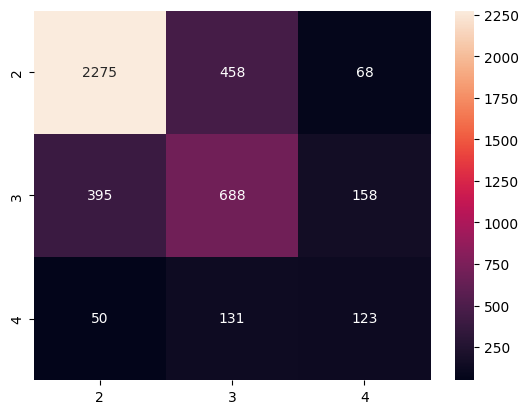

In [17]:
ordem_labels = df["nJets"].unique().tolist()


matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)

sns.heatmap(df_conf, annot=True, fmt="d");

Nota-se que a maior parte das previsões corretas ocorre na classe 2, com 2275 acertos, enquanto as classes 3 e 4 apresentam maior dispersão de erros. Isso ocorre pois a classe 2 apresenta mais exemplos no conjunto de dados, o que faz o modelo aprender melhor seus padrões. Já as demais classes têm menos amostras, resultando em menor precisão nas previsões.

### Explicação do modelo

Para extrair informações do modelo e explicá-lo utilizaremos do `Permutation Importance`. 

O Permutation Importance é uma técnica usada para medir a importância de cada variável em um modelo preditivo. A ideia básica é avaliar quanto a performance do modelo piora quando os valores de uma variável específica são embaralhados (permutados), destrichando a relação dessa variável com a saída. Se a métrica de desempenho do modelo cair significativamente após a permutação, isso indica que a variável é importante para a predição. Por outro lado, se a métrica permanecer quase igual, a variável provavelmente tem pouca influência no modelo. Esse método é particularmente útil porque pode ser aplicado a qualquer modelo, mesmo aqueles que não fornecem diretamente medidas internas de importância dos atributos.

Importância das features (Permutation Importance):
HT: 0.23948038096102842
MR: 0.049729075679199555
Py2: 0.04898259469253903
Px2: 0.04811987824680501
Px1: 0.040424269309331115
Py1: 0.037483728198782054
E1: 0.03424237039852516
Pz1: 0.027488953300243348
E2: 0.018118303227126244
Rsq: 0.015613185720469037
MET: 0.005371236608311292
Pz2: 0.004909242592274587


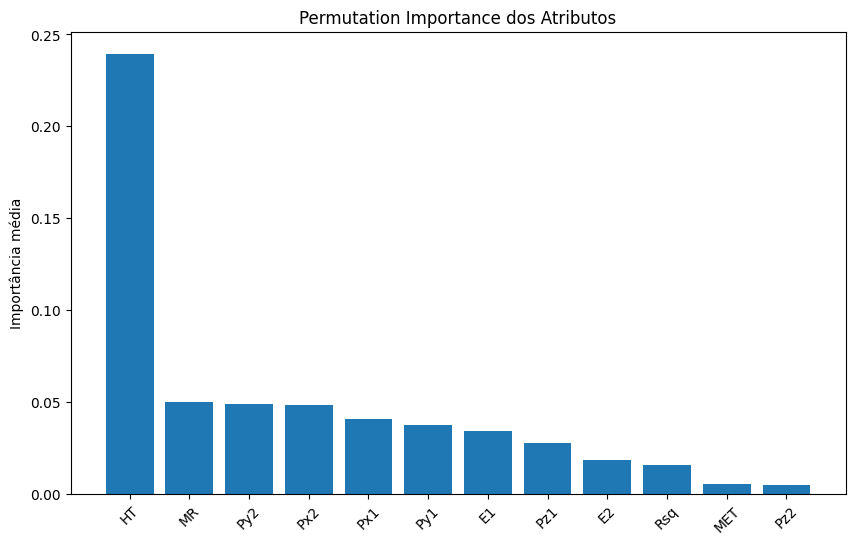

In [31]:
resultado_perm = permutation_importance(
    modelo_ad_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

Observa-se que o atributo HT apresenta disparadamente a maior importância média, indicando ser o principal fator nas previsões. Os demais atributos, como MR, PX2 e PY2, possuem contribuições bem menores, sugerindo que o modelo depende fortemente de HT para distinguir as classes.

Isso acontece porque o atributo HT provavelmente concentra informações mais relevantes ou com maior variação entre as classes, facilitando a distinção feita pelo modelo. Em outras palavras, ele tem maior poder discriminativo.

## K-NN

O algoritmo K-NN calcula a distância entre todos os pontos e aquele cujo target se deseja prever, utilizando um número determinados de pontos mais próximos, chamado "vizinhos", para fazer uma previsão com base em uma estatística aplicada neles. Nesse caso, que é o do classificador K-NN, essa estatística é a moda, ou seja, a previsão será igual à classe que mais se repete dentre dos vizinhos.

Da mesma forma que no modelo anterior, cria-se um `pipeline` contendo o normalizador padrão e o `KNeighborsClassifier`.

In [19]:
modelo_knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

### Estimativa de desempenho

Para uma estimativa inicial de desempenho, é feita validação cruzada _k_-fold que procura manter a proporção entre as classes do target.

In [20]:
metricas = cross_val_score(
    modelo_knn_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

score_medio = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", score_medio)

Valor do F1_weighted em cada fold: [0.65236901 0.65097965 0.64570818 0.65459644 0.6483495  0.64239365
 0.67384852 0.65969269 0.66440267 0.64507859]
Valor médio 0.653741890824304


### Otimização utilizando o `optuna`

A função `cria_instancia_modelo_knn` instancia o modelo utilizando um _trial_ de hiperparâmetros:

In [21]:
def cria_instancia_modelo_knn(trial):
    
    parametros_knn = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1,10000,log=True),
        # número de vizinhos que são considerados para a previsão

        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        # determinar se deve ser atribuído um peso maior aos vizinhos, dentre os sendo considerados, mais próximos em comparação aos mais distantes.
        
        "p": trial.suggest_float("p", 1, 2),
        # distância de minskowski - quando p=1, a distância equivale à de Manhattan, quando p=2, a distância é euclidiana

        "n_jobs": -1
    }

    modelo = KNeighborsClassifier(**parametros_knn)
    return modelo


A função objetivo é responsável por testas os diferentes conjuntos de hiperparâmetros, além d erealizar validação cruzada _k_-fold a fim de estimar de forma mais acurada o desempenho.

In [22]:
def objetivo_knn(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_knn(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()


Cria-se um estudo do `optuna` para a realização desses testes:

In [23]:
nome_do_estudo = "knn_nJets"

study_knn = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db", 
    load_if_exists=True
)

[I 2025-11-04 04:02:01,433] Using an existing study with name 'knn_nJets' instead of creating a new one.


É definida a função `objetivo_parcial_knn` pois o `optuna` só roda o estudo quando a função apresenta apenas um único argumento.

In [24]:
def objetivo_parcial_knn(trial):
    return objetivo_knn(trial, X_treino, y_treino, num_folds)

Procura-se, então, o melhor conjunto de hiperparâmetros dentre 100 tentativas.

In [25]:
num_tentativas = 100
trials_ja_feitos = len(study_knn.trials)
if trials_ja_feitos < num_tentativas:
    study_knn.optimize(objetivo_parcial_knn, n_trials=num_tentativas - trials_ja_feitos)

print("Melhores hiperparâmetros encontrados:")
print(study_knn.best_params)
print(f"Número do melhor trial: {study_knn.best_trial.number}")

Melhores hiperparâmetros encontrados:
{'n_neighbors': 6, 'weights': 'distance', 'p': 1.8587925569678725}
Número do melhor trial: 13


É, então, criado um `pipeline` com esse modelo com esses parâmetros otimizados, cujo desempenho é avaliado.

In [26]:
modelo_knn_pipeline = make_pipeline(
    StandardScaler(),  
    KNeighborsClassifier(**study_knn.best_trial.params)
)

modelo_knn_pipeline.fit(X_treino, y_treino)

y_pred = modelo_knn_pipeline.predict(X_teste)

f1_knn_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_knn_final)


F1-score ponderado final: 0.6553036651387504


Utiliza-se uma matriz de confusão para análise mais detalhada das previsões.

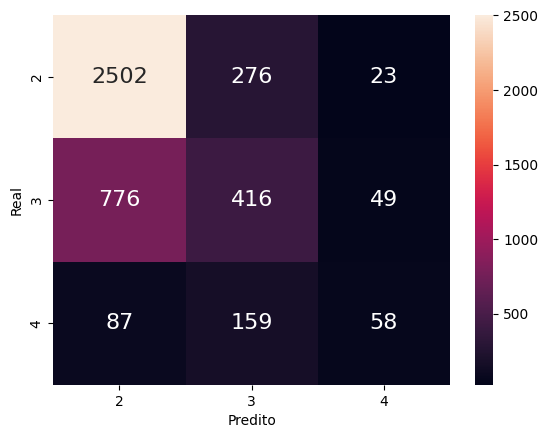

In [27]:
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");

### Explicação do modelo

Pode-se também utilizar a `Permutation Importance` dos atributos visando compreender quais influenciaram mais o modelo.

Importância das features (Permutation Importance):
HT: 0.12028358699303925
Py2: 0.014399506382234483
Px2: 0.011018539252601323
Px1: 0.01096645500623621
E2: 0.00971503478416973
Py1: 0.0060792404341525556
E1: 0.005994357256686333
Rsq: 0.003340835560490496
MET: 0.00204153253119832
Pz2: 0.001400863388000584
MR: 0.0011036932802146238
Pz1: -0.008494729056439864


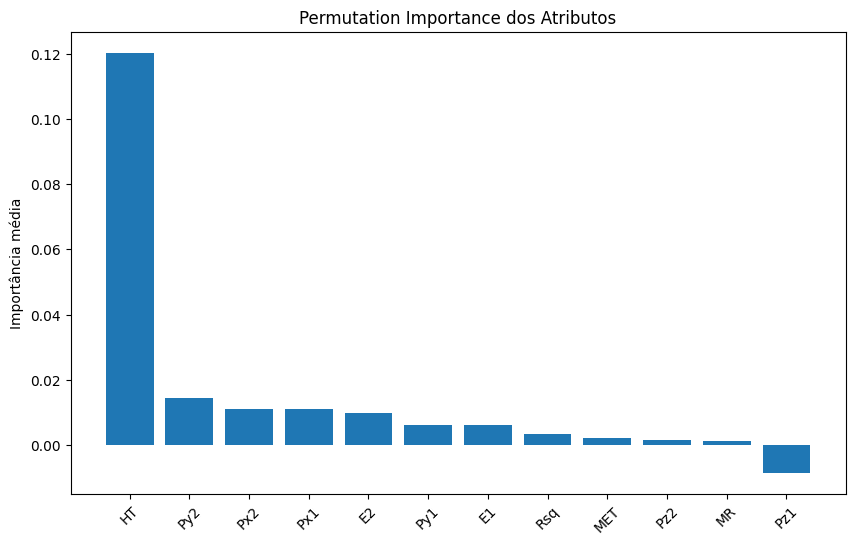

In [30]:
resultado_perm = permutation_importance(
    modelo_knn_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()


## Regressão Logística

O algoritmo de regressão linear Elastic Net se diferencia de uma regressão linear comum, que isso isso e aquilo, devido à regularização. Regularização é uma técnica utilizada para evitar _overfitting_. Seu funcionamento é baseado em diminuir o desempenho local visando incrementar o desempenho geral.

O Elastic Net combina as regularizações L1 (LASSO), e L2 (Ridge). Utiliza-se o LASSO quando o dataset possui dados pouco relevantes. Já o Ridge é utilizado quando se lida com dados muito correlacionados. A Elastic Net, então, lida com datasets que possuem dados muito correlacionados e elimináveis.
 
A regularização L1 introduz um termo controlado pela hiperparâmetro $\lambda$ que reduz coeficientes (isto é, o peso atribuído a cada dado) altos e correlacionados a zero. Isso é feito pois esse termo, chamado de penalização, e é adicionado à soma dos erros quadráticos (SSE).

Já a regularização L2 também insere uma penalização no SSE, porém, ao contrário da L1, ela apenas reduz os coeficientes, e não os apaga.

Para combinar essas duas regularizações, o Elastic Net insere ambas na SSE, selecionando variáveis e lidando com alta correlação. Dessa forma, grupos de variáveis correlacionadas são tratados de forma similar, sem que alguma única variável deles seja zerada ou mantida em contraste com o resto.

Os parâmetros para isso são o $\alpha$ e o $l1ratio$.

O $\alpha$ representa o grau de punição dos coeficientes. Quando $\alpha=0$, a regressão torna-se igual a uma linear convencional. Já $\alpha$s grandes aproximam os coeficientes de zero.

Já o $l1ratio$ representa o balanço entre L1 e L2. Quando $l1ratio=0$, a regularização torna-se exclusivamente L2, e quando $l1ratio=1$, L1.

Pode-se entender isso melhor ao considerar que o que se procura é minimizar a função chamada de custo, a qual, em uma regressão normal, é simplesmente a SSE. Em Elastic Net, é:

$$
custo = SSE + \alpha \left(l1ratio\cdot \sum_i |\beta_i | + (1-l1ratio)\cdot \sum_i \beta_i^2 \right)
$$

Acima, $\beta_i$ representa os coeficientes para cada dado de índice $i$.

In [ ]:
modelo_rl_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

In [ ]:
metricas = cross_val_score(
    modelo_rl_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

In [ ]:
score_medio = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", score_medio)

Valor do F1_weighted em cada fold: [0.59936917 0.59334159 0.61655841 0.61654692 0.61362769 0.61270717
 0.61685023 0.61140598 0.60580773 0.59443384]
Valor médio 0.6080648733946648


In [ ]:
def cria_instancia_modelo_rl(trial):
    
    penalidade = trial.suggest_categorical("penalty", ["l1","l2","elasticnet","none"])
    if penalidade == "l1":
        solvedor = trial.suggest_categorical("solver", ["liblinear", "saga"])
        l1_razao = None
    elif penalidade == "l2":
        solvedor = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "sag", "saga", "liblinear"])
        l1_razao = None
    elif penalidade == "elasticnet":
        solvedor = "saga"
        l1_razao = trial.suggest_float("l1_ratio", 0.0, 1.0)
    else:
        solvedor = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "sag", "saga"])
        l1_razao = None

    parametros_rl = {
    "C": trial.suggest_float("C", 1e-3, 10, log=True),
    "penalty": penalidade,
    "solver": solvedor,
    "class_weight": "balanced",
    "l1_ratio": l1_razao
    }
    
    modelo = LogisticRegression(**parametros_rl)
    return modelo

def objetivo_rl(trial, X, y, num_folds):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    
    modelo = cria_instancia_modelo_rl(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()


In [ ]:
nome_do_estudo = "rl_nJets"

study_rl = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db", 
    load_if_exists=True
)

[I 2025-11-04 03:22:16,698] Using an existing study with name 'rl_nJets' instead of creating a new one.


In [ ]:
def objetivo_parcial_rl(trial):
    return objetivo_rl(trial, X_treino, y_treino, num_folds)

In [ ]:
num_tentativas = 100
trials_ja_feitos = len(study_rl.trials)
if trials_ja_feitos < num_tentativas:
    study_rl.optimize(objetivo_parcial_rl, n_trials=num_tentativas - trials_ja_feitos)

print("Melhores hiperparâmetros encontrados:")
print(study_rl.best_params)
print(f"Número do melhor trial: {study_rl.best_trial.number}")

[W 2025-11-04 03:22:17,234] Trial 3 failed with parameters: {'penalty': 'none'} because of the following error: ValueError('CategoricalDistribution does not support dynamic value space.').
Traceback (most recent call last):
  File "C:\Users\brenda25005\AppData\Roaming\Python\Python312\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\brenda25005\AppData\Local\Temp\ipykernel_10712\2379294661.py", line 2, in objetivo_parcial_rl
    return objetivo_rl(trial, X_treino, y_treino, num_folds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\brenda25005\AppData\Local\Temp\ipykernel_10712\2498376029.py", line 30, in objetivo_rl
    modelo = cria_instancia_modelo_rl(trial)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\brenda25005\AppData\Local\Temp\ipykernel_10712\2498376029.py", line 14, in cria_instancia_modelo_rl
    solvedor = trial.suggest_categor

ValueError: CategoricalDistribution does not support dynamic value space.

In [ ]:
modelo_rl_pipeline = make_pipeline(
    StandardScaler(),  
    LogisticRegression(**study_rl.best_trial.params)
)

modelo_rl_pipeline.fit(X_treino, y_treino)

y_pred = modelo_rl_pipeline.predict(X_teste)

f1_rl_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_rl_final)

## Floresta aleatória

O algoritmo da floresta aleatória é baseado em comitê. Seu princípio é utilizar árvores de decisão, sendo que cada uma realiza sua própria previsão. Sabe-se que a árvore de decisão é um modelo de alto viés e baixa variância. Combinando, porém, diversos desses modelos, objetiva-se encontrar um de baixo viés e alta variância. Ou seja, procura-se um aumento do desempenho desse modelo de comitê em comparação com algum de não o seja.

Seguindo o mesmo princípio de criação 

In [ ]:
modelo_rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

### Estimativa de desempenho

In [ ]:
metricas = cross_val_score(
    modelo_rf_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

score_medio = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", score_medio)

Valor do F1_weighted em cada fold: [0.75367199 0.74309514 0.75829669 0.76237854 0.74637078 0.7420672
 0.77221278 0.75949239 0.75980924 0.75710594]
Valor médio 0.755450069441048


### Otimização utilizando o `optuna`

In [ ]:
def cria_instancia_modelo_rf(trial):
    
    parametros_rf = {
        "n_estimators": trial.suggest_int("num_arvores", 5, 300, log=True),
        "criterion": trial.suggest_categorical("criterio", ['gini', 'log_loss', 'entropy']),
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 20),
        "max_features": trial.suggest_float("num_max_atributos", 0.0, 1.0),
        "bootstrap": True,
        "class_weight": "balanced",
        "n_jobs": -1,
        "random_state": 42,
    }

    modelo = RandomForestClassifier(**parametros_rf)
    return modelo


In [ ]:
def objetivo_rf(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_rf(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()


In [ ]:
nome_do_estudo = "random_forest_nJets"

study_rf = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db", 
    load_if_exists=True
)

[I 2025-11-04 00:08:35,117] A new study created in RDB with name: random_forest_nJets


In [ ]:
def objetivo_parcial_rf(trial):
    return objetivo_rf(trial, X_treino, y_treino, num_folds)

num_tentativas = 100
trials_ja_feitos = len(study_rf.trials)
if trials_ja_feitos < num_tentativas:
    study_rf.optimize(objetivo_parcial_rf, n_trials=num_tentativas - trials_ja_feitos)

print("Melhores hiperparâmetros encontrados:")
print(study_rf.best_params)
print(f"Número do melhor trial: {study_rf.best_trial.number}")

Melhores hiperparâmetros encontrados:
{'num_arvores': 218, 'criterio': 'log_loss', 'min_exemplos_split': 5, 'min_exemplos_folha': 2, 'num_max_atributos': 0.9695687798744911}
Número do melhor trial: 72


In [ ]:
modelo_rf_pipeline = make_pipeline(
    StandardScaler(),  
    RandomForestClassifier(**study_rf.best_trial.params)
)

modelo_rf_pipeline.fit(X_treino, y_treino)

y_pred = modelo_rf_pipeline.predict(X_teste)

f1_rf_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_rf_final)

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'num_arvores'

### Explicação do modelo

In [ ]:
resultado_perm = permutation_importance(
    modelo_rf_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs = -1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

## SVM

O SVM (Support Vector Machine) é um algoritmo de classificação que busca encontrar a melhor fronteira de separação entre diferentes classes nos dados. Essa fronteira, chamada de hiperplano, divide o espaço de atributos de modo a maximizar a distância entre os pontos de diferentes classes, garantindo uma separação mais robusta [Figura 5].

O funcionamento do SVM consiste em analisar todos os exemplos disponíveis e identificar os vetores de suporte, que são os pontos mais próximos do hiperplano e que determinam a posição ótima da fronteira. A partir desses vetores, o algoritmo ajusta o hiperplano para maximizar a margem entre as classes.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/svm.png" alt="Estrutura comum do SVM" width="600">
  <figcaption><b>Figura 5.</b> Estrutura comum do SVM.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Riccardo Andreoni - towardsdatascience.com</figcaption>
</figure>
<br>

Induziremos um modelo de SVM classificador (SVC) para prever nJets a partir dos atributos selecionados. Usaremos do mesmo pipeline de antes, que inclui padronização dos dados e a fittagem do modelo. Posteriormente, faremos a otimização dos hiperparâmetros pelo Optuna para obter o melhor desempenho.

In [34]:
modelo_svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(random_state=semente_aleatoria, class_weight="balanced")
)

### Estimativa de desempenho

Da mesma maneira de antes, iremos usar a validação cruzada `StratifiedKFold` para gerar uma estimativa do desempenho do modelo nos dados de X_treino e y_treino.



In [35]:
metricas = cross_val_score(
    modelo_svm_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_svm = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_svm)

Valor do F1_weighted em cada fold: [0.79774015 0.79390149 0.78327918 0.78342335 0.7813246  0.78782463
 0.78339284 0.7933292  0.78652956 0.78425381]
Valor médio 0.7874998820794926


### Otimização utilizando Optuna

Da mesma forma que fizemos para a árvore de decisão, utilizaremos do Optuna para otimizar os hiperparâmetros do modelo.

Começamos definindo uma função `cria_instancia_modelo_svm(trial)`, que irá utilizar do Optuna para sugerir valores do Support Vector Classifier.

In [36]:
def cria_instancia_modelo_svm(trial):
    
    # Sugerindo hiperparâmetros com Optuna
    parametros_svm = {
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),  
        # Parâmetro de regularização. Valores maiores tentam classificar todos os pontos corretamente, valores menores aumentam a margem.
        
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),  
        # Tipo de kernel usado pelo SVM. "linear" = separação linear, "poly" = polinomial, "rbf" = radial, "sigmoid" = sigmoide.
        
        "degree": trial.suggest_int("degree", 2, 5),  
        # Grau do polinômio (usado apenas se kernel="poly")
        
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),  
        # Coeficiente do kernel para "rbf", "poly" e "sigmoid". "scale" = 1 / (n_features * X.var()), "auto" = 1 / n_features.
        
        "class_weight": "balanced",  
        # Ajusta os pesos das classes para lidar com desbalanceamento
        
        "random_state": semente_aleatoria,  
        # Semente aleatória para reprodutibilidade
    }
    
    # Criando pipeline com padronização dos dados
    modelo = make_pipeline(
        StandardScaler(),
        SVC(**parametros_svm)
    )
    
    return modelo

Agora, desenvolveremos a `função objetivo_svm`, que avalia o desempenho do modelo SVM para diferentes combinações de hiperparâmetros sugeridas pelo Optuna, utilizando validação cruzada e a métrica F1-weighted.



In [37]:
def objetivo_svm(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_svm(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()

Em seguida, vamos criar o objeto de estudo do Optuna, responsável por registrar os resultados da otimização para que possam ser reutilizados posteriormente, evitando a execução repetida do processo.

In [38]:
nome_do_estudo = "svm_nJets"
pasta = "Estudos do Optuna"
caminho_db = f"{pasta}/{nome_do_estudo}"


study_svm = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///{caminho_db}.db", 
    load_if_exists=True
)

[I 2025-11-04 04:21:48,615] Using an existing study with name 'svm_nJets' instead of creating a new one.


Como explicado anteriormente, criaremos a função `objetivo_parcial_svm` para que o Optuna consiga executar o processo de otimização de forma mais simples.



In [39]:
def objetivo_parcial_svm(trial):
    return objetivo_svm(trial, X_treino, y_treino, num_folds)

Executaremos o Optuna para a otimização dos hiperparâmetros, utilizando o número de 100 trials.



In [40]:
trials_ja_feitos = len(study_svm.trials)
if trials_ja_feitos < num_tentativas:
    study_svm.optimize(objetivo_parcial_svm, n_trials=num_tentativas - trials_ja_feitos)

In [42]:
print("Melhores hiperparâmetros encontrados:")
print(study_svm.best_params)
print(f"Número do melhor trial: {study_svm.best_trial.number}")
print(f"Melhor valor de F1: {study_svm.best_value}")

Melhores hiperparâmetros encontrados:
{'C': 98.58836215851876, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}
Número do melhor trial: 52
Melhor valor de F1: 0.8648376160761477


### Avaliação de desempenho

## Comparação do desempenho

comparar o resultado de cada modelo

da pra incluir alguns graficos de dados reais/previstos

## Discussão dos resultados

discussao de tudo

## Conclusão

Não precisa ser longo, 2 paragrafos ja ta bom

## Referências

Ir citando conforme necessario